# Multitask Modeling example - classification

In [1]:
import pandas as pd
import matplotlib_venn as mpv

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_plots as pp

from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp

/Users/echun/repos/AMPL/atomsci/ddm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/echun/repos/atomsci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [30]:
# df=pd.read_csv('../datasets/cell_health_MT.csv')
df=pd.read_csv("/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_supps.csv")
print(df.shape)
df.head()

(6553, 9)


,compound_id,base_rdkit_smiles,active_ROS,active_MMP,active_CellCount,active_MitoStruct,active_GSH,active_NucMask,active_NucArea
0,ALWUKGXLBSQSMA,CCCCCCC1(C)CCC(=O)O1,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,BVUXDWXKPROUDO,CCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,BZNDWPRGXNILMS,CCNP(=S)(OC)O/C(C)=C/C(=O)OC(C)C,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,CBQGYUDMJHNJBX,CCOc1ccccc1O[C@H](c1ccccc1)[C@H]1CNCCO1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,CIDUJQMULVCIBT,CCN[C@@H]1C[C@H](N)[C@@H](OC2OC(CN)=CCC2N)[C@H...,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df.columns

Index(['compound_id', 'base_rdkit_smiles', 'active_ROS', 'active_MMP',
       'active_CellCount', 'active_MitoStruct', 'active_GSH', 'active_NucMask',
       'active_NucArea'],
      dtype='object')

## Create a multitask scaffold split
Here we simply specify the `splitter` as `multitaskscaffold`. There are several mtss (parameters)[https://github.com/ATOMScience-org/AMPL/blob/master/atomsci/ddm/docs/PARAMETERS.md] that can be modified. We recommend first playing around with `mtss_num_super_scaffolds` which sets number of groupings of singleton scaffolds or those that cluster into very small groups. Values from 20-160 can be used to ensure that all classes are represented from all tasks in all partitions.

In [41]:
dataset_file = '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_supps.csv'
# dataset_file = "/g/g16/apaulson/workspace/github_repos/DILI/datasets/training_data/DILIst_smiles.csv"
# odir = '../datasets/'
odir="/Users/echun/repos/DILI-rotation/AMPL_models/datasets/"

params = {
    "verbose": "True",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    
    "response_cols" : ['active_MMP','active_CellCount','active_MitoStruct','active_ROS','active_GSH','active_NucMask','active_NucArea'],
    # "response_cols" : "DILIst_Classification",
    
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "True",
    "split_uuid": "eb08712e-f082-4e30-a663-333b9d12cffe",
    
    "splitter": 'multitaskscaffold',
    
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",
    
    "mtss_num_super_scaffolds":"40", # default 40, change this parameter if you don't get all classes and tasks in each partition
    "mtss_train_valid_dist_weight": "1.0",
    "mtss_train_test_dist_weight": "1.0",
    "mtss_split_fraction_weight": "1.0",
    "mtss_response_distr_weight": "5.0",
    "mtss_num_generations": "100",
    
    # featurization & training params
    "previously_featurized":"True",
    "featurizer": "computed_descriptors",
    "descriptor_type":"rdkit_raw"
    
}

In [ ]:
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
split_uuid = MP.split_dataset()

In [ ]:
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{split_uuid}*")[0]
split_file

In [ ]:
split_df = pd.read_csv(split_file)
split_df.subset.value_counts()

### Visualize the split

In [32]:
import glob
import os

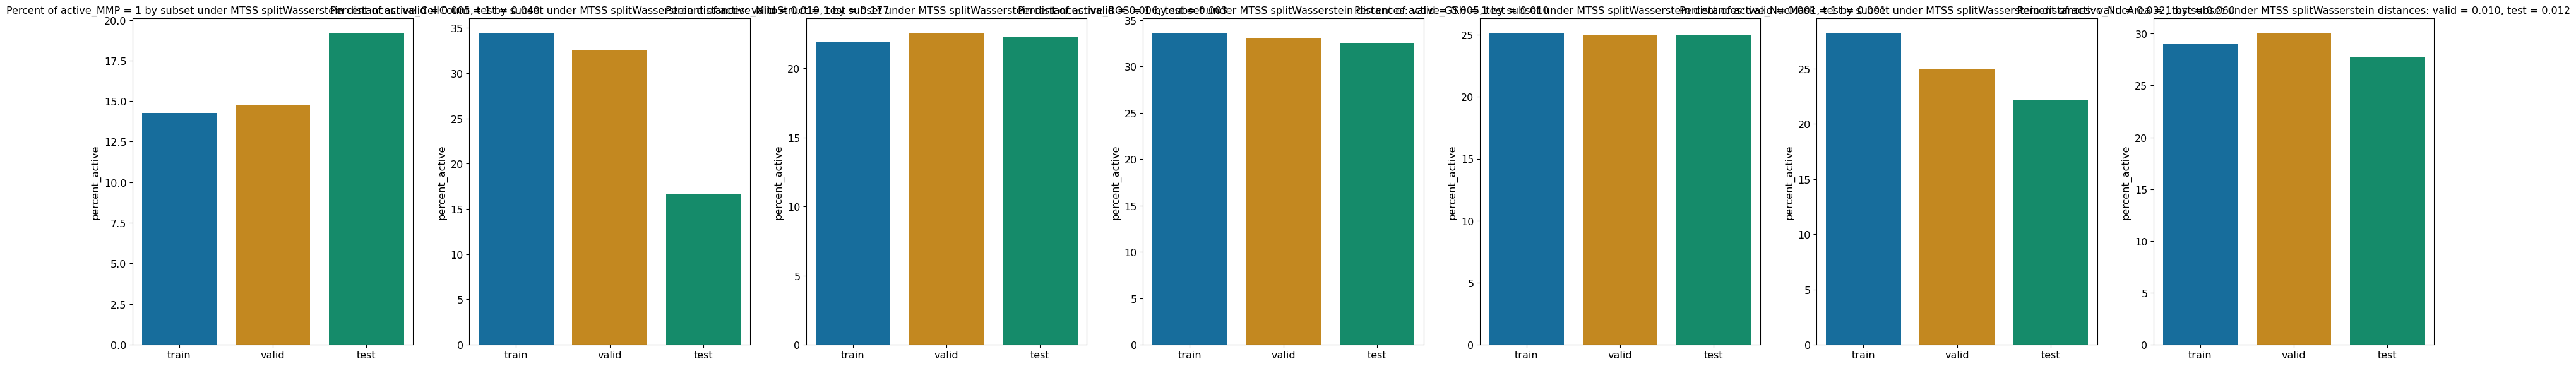

In [33]:
dataset_file = '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_suppsR.csv'
response_col = 'active_MMP,active_CellCount,active_MitoStruct,active_ROS,active_GSH,active_NucMask,active_NucArea'
# response_col="active"
id_col = "compound_id"
smiles_col = "base_rdkit_smiles"

import atomsci.ddm.utils.split_response_dist_plots as srdp

split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : smiles_col,
    "prediction_type": "classification",
    "response_cols" : response_col,
    "split_uuid": "eb08712e-f082-4e30-a663-333b9d12cffe",
    "splitter": 'multitaskscaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

Ideally, we see similar percentages of the positive class in each partition. As more tasks are added and as fewer compounds overlap between tasks, this problem becomes more challenging. Since our dataset has only 47 overlapping compounds, these percentages are inevitably going to be more variable than a dataset with more overlapping compounds.

/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_suppsR_train_valid_test_multitaskscaffold_eb08712e-f082-4e30-a663-333b9d12cffe.csv


/Users/echun/repos/AMPL/atomsci/ddm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/echun/repos/AMPL/atomsci/ddm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/echun/repos/AMPL/atomsci/ddm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/echun/repos/AMPL/atomsci/ddm/__init__.py:1: U

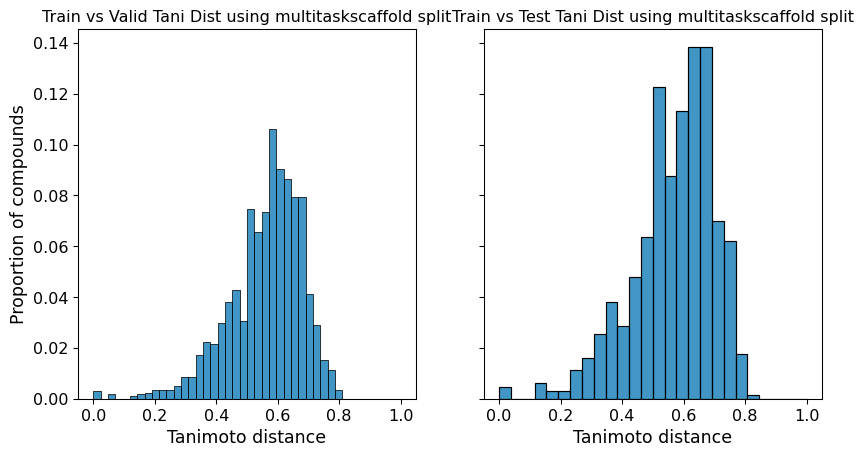

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

split_uuid = "eb08712e-f082-4e30-a663-333b9d12cffe"

# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{split_uuid}*")[0]
print(split_file)

# read the dataset
df = pd.read_csv(dataset_file)
response_cols = params['response_cols'].split(',')

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=response_cols)

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tani Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tani Dist using {split_type} split");

We can also visualize the tanimoto distance distribution of validation and test set compounds to the nearest neighbor in the training dataset. Here we can see that the scaffold split was more or less successful in making each partition structurally distinct (Tanimoto distances > ~0.5) from the training set.

### Look at counts of each class, in each split, for each task
As a final gut check, we can make sure there is at least one compound from each class in each split partition for all tasks. We use the Pandas `value_counts()` function on two columns jointly to output the counts. This function by default excludes NaN's from its list.

In [34]:
dat=df.merge(split, how='inner', left_on='compound_id', right_on='cmpd_id')
dat.head(2)

,compound_id,base_rdkit_smiles,active_ROS,active_MMP,active_CellCount,active_MitoStruct,active_GSH,active_NucMask,active_NucArea,cmpd_id,subset,fold
0,ALWUKGXLBSQSMA,CCCCCCC1(C)CCC(=O)O1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,ALWUKGXLBSQSMA,valid,0
1,BVUXDWXKPROUDO,CCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,BVUXDWXKPROUDO,valid,0


In [37]:
# inhibition
# dat[['subset','active_MMP']].value_counts()
# dat[['subset','DILIst_Classification']].value_counts()

In [ ]:
# binding
dat[['subset','active_CellCount']].value_counts()

## Train a model
When we're happy with the split distributions, we can use the split_uuid and train a multitask NN model. Here we select rdkit_raw features.

In [38]:
dataset_file = '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_suppsR.csv'
split_uuid = "eb08712e-f082-4e30-a663-333b9d12cffe"
odir="/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/"

In [39]:
params = {

    "dataset_key" : dataset_file,
    "smiles_col" : smiles_col,
    "prediction_type": "classification",
    "response_cols" : response_col,
    "split_uuid": split_uuid,
    "splitter": 'multitaskscaffold',
    
    # dataset info
    "id_col": "compound_id",
    "result_dir": odir,

    # splitting
    "previously_split": "True",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type":"rdkit_raw",
    "prediction_type": "classification",
    
    "model_type": "NN",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "learning_rate": "0.0002",
    "max_epochs": "300",
    "early_stopping_patience": "50",
    "transformers":None,
    "verbose": "True",
}
pparams = parse.wrapper(params)
classif_pipe = mp.ModelPipeline(pparams)
classif_pipe.train_model()

/Users/echun/repos/AMPL/atomsci/ddm/pipeline/transformations.py:308: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


['/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/cell_health_MT_suppsR/NN_computed_descriptors_multitaskscaffold_classification/dfa0bbff-5cc9-4375-959d-435982fb50ba/model/checkpoint1.pt', '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/cell_health_MT_suppsR/NN_computed_descriptors_multitaskscaffold_classification/dfa0bbff-5cc9-4375-959d-435982fb50ba/model/checkpoint2.pt', '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/cell_health_MT_suppsR/NN_computed_descriptors_multitaskscaffold_classification/dfa0bbff-5cc9-4375-959d-435982fb50ba/model/checkpoint3.pt', '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/cell_health_MT_suppsR/NN_computed_descriptors_multitaskscaffold_classification/dfa0bbff-5cc9-4375-959d-435982fb50ba/model/checkpoint4.pt', '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/MT_models/cell_health_MT_suppsR/NN_computed_descriptors_multitaskscaffold_classification/dfa0bbff-5cc9-4375-959d-435982fb50ba/mo

In [16]:
import pandas as pd
import glob, os

dataset_file = '/Users/echun/repos/DILI-rotation/AMPL_models/datasets/cell_health_MT_suppsR.csv'
split_uuid = "eb08712e-f082-4e30-a663-333b9d12cffe"

# Load data
df = pd.read_csv(dataset_file)
split_file = glob.glob(f"{os.path.dirname(dataset_file)}/*{split_uuid}*.csv")[0]
split_df = pd.read_csv(split_file)

# Merge train split
train_df = df.merge(split_df[split_df.subset=='train'], left_on='compound_id', right_on='cmpd_id')

print("=== TRAIN SPLIT STATS ===")
print(f"Total train compounds: {len(train_df)}")
for col in df.columns[df.columns.str.contains('active')]:
    positives = train_df[col].sum()
    pct = 100 * positives / len(train_df)
    print(f"{col}: {positives} positives ({pct:.2f}%)")


=== TRAIN SPLIT STATS ===
Total train compounds: 4170
active_MMP: 584.0 positives (14.00%)
active_CellCount: 89.0 positives (2.13%)
active_MitoStruct: 57.0 positives (1.37%)
active_ROS: 102.0 positives (2.45%)
active_GSH: 65.0 positives (1.56%)
active_NucMask: 73.0 positives (1.75%)
active_NucArea: 75.0 positives (1.80%)


## Visualize model performance

In [ ]:
pp.plot_perf_vs_epoch(classif_pipe)


In [ ]:
pp.plot_confusion_matrices('./ST_models/ROS_models/ROS_hits_up_class_curMoe_model_e8a2a7e4-354e-4962-9829-da1ece0378b4.tar.gz')

From the confusion matrices and model metrics plots, we can see that while the binding dataset is larger, it is not very well-predicted in this model, while the inhibition dataset does better.

In [ ]:
pp.plot_model_metrics('./ST_modelsMMP/MMP_models/MMP_tox21_curMoe_model_816056c0-93e0-4157-86ad-8f14cfb942f8.tar.gz', plot_size=8)
pp.plot_model_metrics('./ST_modelsMMP/MMP_models/MMP_tox21_curMoe_model_797c3701-0e7d-4bda-b098-3d9e330485bc.tar.gz', plot_size=8)
pp.plot_model_metrics('./ST_modelsMMP/MMP_models/MMP_tox21_curMoe_model_ad7aa1b8-4e18-4e83-9e2b-ceb3a535f4d1.tar.gz', plot_size=8)
pp.plot_model_metrics('./ST_modelsMMP/MMP_models/MMP_tox21_curMoe_model_2204d893-a84d-4bfc-96f2-1bcc201c8731.tar.gz', plot_size=8)

Given the rather mediocre recall performance of our model for the binding task, we would like to try training a new model that has better recall without sacrificing too much precision. One way to do this is to change the `model_choice_score_type` parameter to optimize the number of training epochs for a metric that balances precision and recall. **[Balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)** and the **[Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Phi_coefficient)** are two such metrics often used for this purpose.
We'll try out using the `MCC`, with all other parameters left the same.

## Change model_choice_score_type

In [3]:
dataset_file = "../datasets_ST/MMP/scaled_descriptors/MMPcleanR.csv"
odir="/Users/echun/repos/DILI-rotation/datasets_ST/ST_model_opt/"
split_uuid = "8507d7de-0beb-4c8b-9f3b-26f7d34293d3"

In [3]:
params = {

    "dataset_key" : dataset_file,
    "smiles_col" : "base_rdkit_smiles",
    "prediction_type": "classification",
    # "response_cols" : response_col,
    "response_cols" : "active",
    "split_uuid": split_uuid,
    "splitter": 'scaffold',
    
    # dataset info
    "id_col": "compound_id",
    "result_dir": odir,

    # splitting
    "previously_split": "True",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type":"rdkit_raw",
    "prediction_type": "classification",
    "model_type": "xgboost", #change

    # "layer_sizes": "128,64",
    # "dropouts": "0.3,0.3",
    # "learning_rate": "0.0002",
    # "max_epochs": "300",
    # "early_stopping_patience": "50",

    # "rfe": "uniformint|248",
    # "rfd": "uniformint|8",
    # "rff": "uniformint|41",

    "xgbg": "uniform|0.08622693624423464", # gamma
    "xgbn": "uniformint|458", # num_estimators
    "xgbd": "uniformint|2", # max_depth
    "xgbw": "uniform|1.095413707975731", # min_child_weight
    "xgbl": "loguniform|0.08510939076026015", # learning rate
    "xgbc": "uniform|0.2677756446355035", # colsample_bytree
    "xgbs": "uniform|0.5219102239548399", # subsample

    "verbose": "True",
    
    "model_choice_score_type": "mcc",

}
pparams = parse.wrapper(params)
classif_pipe = mp.ModelPipeline(pparams)
classif_pipe.train_model()

/Users/echun/repos/AMPL/atomsci/ddm/pipeline/transformations.py:308: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
/Users/echun/repos/atomsci/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:08:23] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/Users/echun/repos/atomsci/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:08:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_gpus", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
pp.plot_perf_vs_epoch(classif_pipe)

Here we see two plots for ROC_AUC and MCC scores per epoch. During training, the best epoch was chosen based on the highest MCC value, even though this corresponds to and epoch with deteriorating ROC_AUC scores. Let's take a look at the confusion matrices to see false negatives and false positives:

In [ ]:
import atomsci.ddm.pipeline.compare_models as cm
result_df = cm.get_filesystem_perf_results(
    result_dir = odir,
    pred_type='classification'
)

result_df = result_df.sort_values(by='best_valid_roc_auc_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_roc_auc_score','best_test_roc_auc_score']].head()

In [ ]:
pp.plot_confusion_matrices(classif_pipe)
pp.plot_model_metrics(classif_pipe, plot_size=8)

Compared to our base classifier above, optimizing toward MCC did improve prediction performance for both binding and inhibition tasks. Let's see if we can reduce the false negatives by also including a balancing weight transformer to deal with the imbalance in the dataset:

## Change weight_transform_type

In [7]:
params = {

    "dataset_key" : dataset_file,
    "smiles_col" : "base_rdkit_smiles",
    "prediction_type": "classification",
    "response_cols" : "active",
    "split_uuid": split_uuid,
    "splitter": 'scaffold',
    
    # dataset info
    "id_col": "compound_id",
    "result_dir": odir,

    # splitting
    "previously_split": "True",
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type":"rdkit_raw",
    "prediction_type": "classification",
    "model_type": "xgboost",

    # "layer_sizes": "128,64",
    # "dropouts": "0.3,0.3",
    # "learning_rate": "0.0002",
    # "max_epochs": "300",
    # "early_stopping_patience": "50",

    # "rfe": "uniformint|248",
    # "rfd": "uniformint|8",
    # "rff": "uniformint|41",

    "xgbg": "uniform|0.08622693624423464", # gamma
    "xgbn": "uniformint|458", # num_estimators
    "xgbd": "uniformint|2", # max_depth
    "xgbw": "uniform|1.095413707975731", # min_child_weight
    "xgbl": "loguniform|0.08510939076026015", # learning rate
    "xgbc": "uniform|0.2677756446355035", # colsample_bytree
    "xgbs": "uniform|0.5219102239548399", # subsample

    "verbose": "True",
    
    "model_choice_score_type": "mcc",

    "weight_transform_type": "balancing",


}
pparams = parse.wrapper(params)
classif_pipe = mp.ModelPipeline(pparams)
classif_pipe.train_model()

/Users/echun/repos/AMPL/atomsci/ddm/pipeline/transformations.py:308: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
/Users/echun/repos/atomsci/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_gpus", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# pp.plot_perf_vs_epoch(classif_pipe)

pp.plot_confusion_matrices(classif_pipe)
pp.plot_model_metrics(classif_pipe, plot_size=8)

With balancing weights, we were indeed able to shift away from false negatives, but instead maybe we're overcorrecting towards too many false positives. Depending on the model use case, this might be a favorable overcorrection. For example if your classes are 1=inhibitor and 0=not-inhibitor and you have plenty of samples and testing capabilities, you might err on the side of many false positives in order to find every possible true positive.

## examine dataset
- we can see weights and other dataset information inside the `classif_pipe.data.dataset` object.

In [ ]:
# compound ids
classif_pipe.data.dataset.ids

In [ ]:
# rdkit_raw features for each compound
print(classif_pipe.data.dataset.X.shape)
classif_pipe.data.dataset.X

In [ ]:
# 2 tasks' worth of response values
# note - instead of NaN's here they are filled in with 0's. The "missing values" are reflected in the weights.
print(classif_pipe.data.dataset.y.shape)
classif_pipe.data.dataset.y

In [ ]:
# weights - here 0's mean weight this as 0 for this task because there is no ground truth response value for this compound
print(classif_pipe.data.dataset.w.shape)
classif_pipe.data.dataset.w

In [ ]:
split_uuid

In [4]:
model_dir = f'./datasets_ST/ST_model_opt'

result_df = cm.get_filesystem_perf_results(
    result_dir = odir,
    pred_type='classification'
)

result_df = result_df.sort_values(by='best_valid_roc_auc_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_roc_auc_score','best_test_roc_auc_score']].head()

Found data for 2 models under /Users/echun/repos/DILI-rotation/datasets_ST/ST_model_opt/


,model_uuid,model_parameters_dict,best_valid_roc_auc_score,best_test_roc_auc_score
0,4a7e2b0b-0347-43ab-b550-26147e3cf5ee,"{""xgb_alpha"": 0.0, ""xgb_colsample_bytree"": 1.0...",0.802198,0.793084
1,032cdc8a-35df-46d9-b439-0fed42421f4d,"{""xgb_alpha"": 0.0, ""xgb_colsample_bytree"": 1.0...",0.802051,0.771149


In [6]:
model_uuid = "4a7e2b0b-0347-43ab-b550-26147e3cf5ee"
model_info = result_df[result_df["model_uuid"]==model_uuid]
pd.set_option('display.max_colwidth', 500)
print(model_info[['model_uuid',
                  'model_parameters_dict',
                  'best_train_roc_auc_score',
                  'best_valid_roc_auc_score',
                  'best_test_roc_auc_score']])

                             model_uuid  \
0  4a7e2b0b-0347-43ab-b550-26147e3cf5ee   

                                                                                                                                                                                            model_parameters_dict  \
0  {"xgb_alpha": 0.0, "xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0, "xgb_lambda": 1.0, "xgb_learning_rate": 0.1, "xgb_max_depth": 6, "xgb_min_child_weight": 1.0, "xgb_n_estimators": 100, "xgb_subsample": 1.0}   

   best_train_roc_auc_score  best_valid_roc_auc_score  best_test_roc_auc_score  
0                  0.998671                  0.802198                 0.793084  


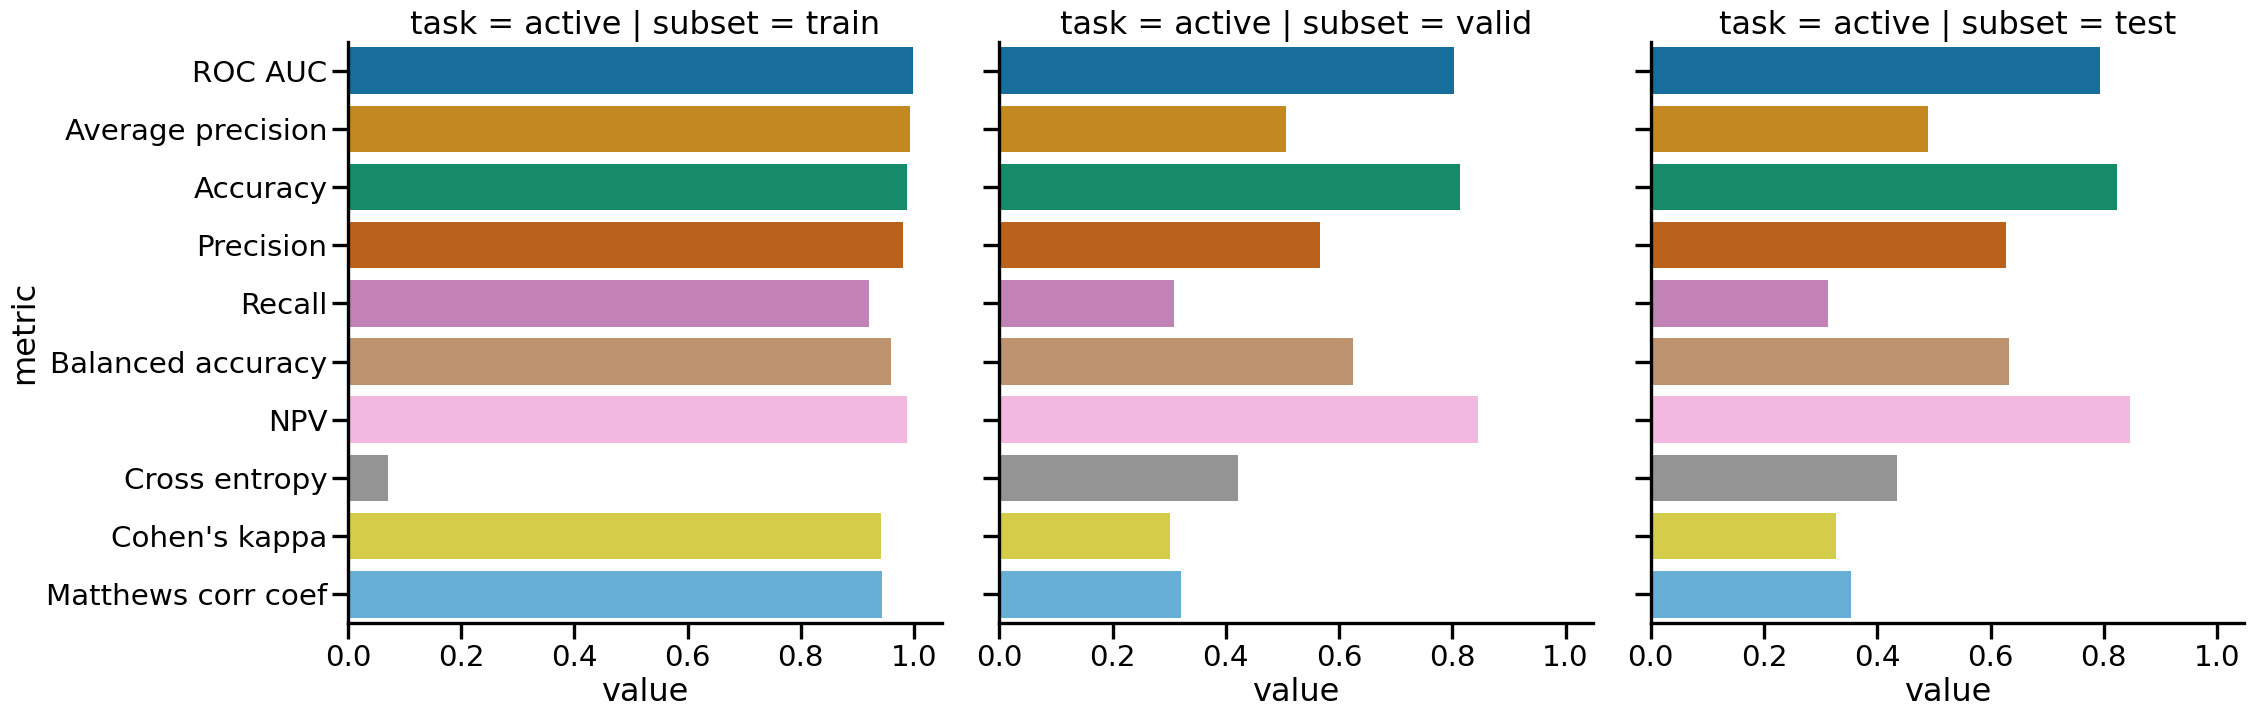

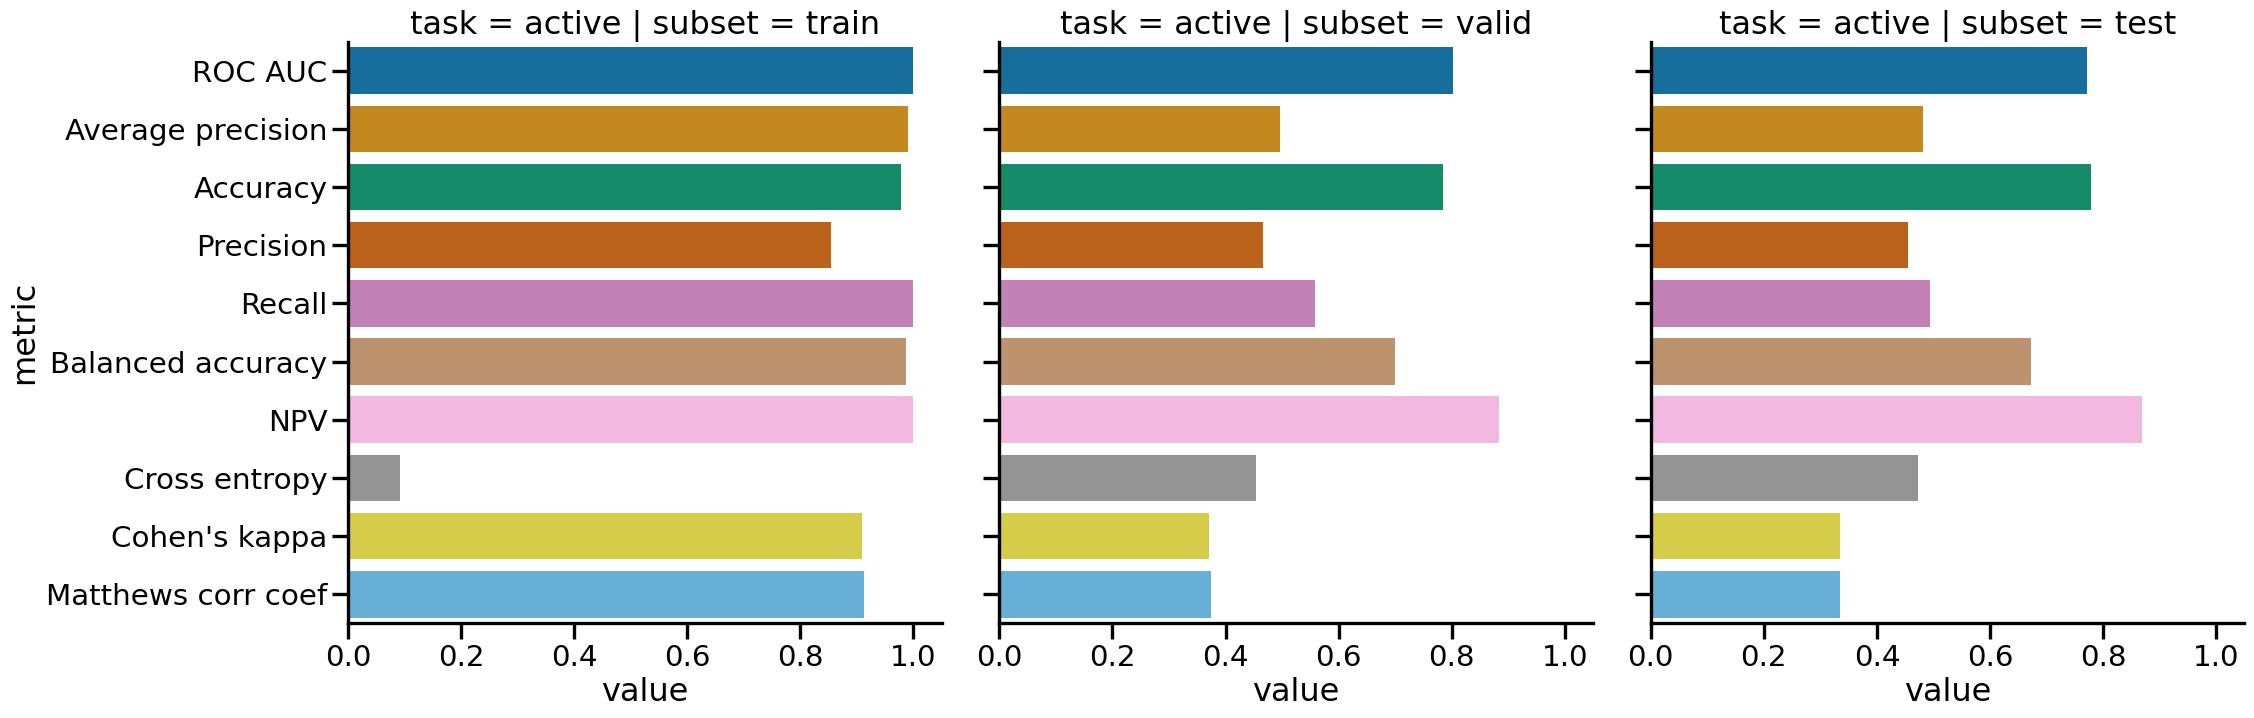

In [5]:
pp.plot_model_metrics('../datasets_ST/ST_model_opt/MMPcleanR_model_4a7e2b0b-0347-43ab-b550-26147e3cf5ee.tar.gz', plot_size=8)
pp.plot_model_metrics('../datasets_ST/ST_model_opt/MMPcleanR_model_032cdc8a-35df-46d9-b439-0fed42421f4d.tar.gz', plot_size=8)